In [3]:
import os
import numpy as np
import xarray as xr
import pandas as pd
from datetime import datetime
from datetime import timedelta
import glob
import seaborn as sns
# packages for plotting
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from matplotlib.colors import ListedColormap


In [4]:
from configobj import ConfigObj

In [4]:
!cat /home7/datahome/marc/lib_operational_chain/data_oco/config_MARC_F1-MARS3D-MANGAE2500.cfg

[config]
  oco_dir_best = '/home/ref-marc/f1_e2500/best_estimate/'
  oco_name = 'MARC_F1-MARS3D-MANGAE2500'
  oco_grid = 'oriented'
  frequency = 1
  echeances = 96
  suffix = ''
  model_avaibility_start_date = '2006-01-01 00:00:00'
  model_avaibility_end_date = None
  date_format = '%Y%m%dT%H%MZ'
  date_format_FILTRE = '%Y%m%dT1200Z'
  dap_url = "http://tds1.ifremer.fr/thredds/dodsC/MARC-MANGAE2500-MARS3D_F1-FOR_FULL_TIME_SERIE"
  dim_ni = 822
  dim_nj = 624
  dim_level = 40
  dim_time = 1
  nb_vars = 13


### Créer les paramètres

In [5]:
config = ConfigObj("/home7/datahome/marc/lib_operational_chain/data_oco/config_MARC_F2-MARS3D-MENOR1200.cfg")
#config = ConfigObj("/home7/datahome/marc/lib_operational_chain/data_oco/config_MARC_F1-MARS3D-MANGAE2500.cfg")

In [6]:
config['config']

{'oco_dir_best': '/home/ref-marc/f2_1200_sn/best_estimate', 'oco_name': 'MARC_F2-MARS3D-MENOR1200', 'oco_grid': 'oriented', 'frequency': '3', 'echeances': '96', 'suffix': '', 'model_avaibility_start_date': '2015-01-01 00:00:00', 'model_avaibility_end_date': 'None', 'date_format': '%Y%m%dT%H%MZ', 'dap_url': 'http://tds1.ifremer.fr/thredds/dodsC/MARC-MENOR1200-MARS3D_F2-FOR_FULL_TIME_SERIE', 'dim_ni': '1101', 'dim_nj': '463', 'dim_level': '60', 'dim_time': '1', 'nb_vars': '15'}

In [7]:
startDate=config['config']['model_avaibility_start_date']   
startDate

'2015-01-01 00:00:00'

In [8]:
int(config['config']['echeances'])/24

4.0

In [9]:
endDate = datetime.now()+timedelta(days=int(config['config']['echeances'])/24)  # aujourd'hui + 4 jours de forecasting
#endDate = datetime.fromisoformat(startDate)+timedelta(days=1)

In [10]:
endDate = endDate.strftime("%Y%m%d")
endDate

'20220625'

In [11]:
frequence = config['config']['frequency'] + 'H' # MANGAE2500=3h ,MENOR1200=1h
frequence

'3H'

In [12]:
refDir = config['config']['oco_dir_best']
refDir

'/home/ref-marc/f2_1200_sn/best_estimate'

In [13]:
filePrefix = config['config']['oco_name']
filePrefix

'MARC_F2-MARS3D-MENOR1200'

In [14]:
#dsx = xr.open_mfdataset(glob.glob(os.path.join(refDir,"2018",filePrefix+'_'+"20180513T*Z.nc")),chunks=0)
#dsx

# Vérification dans le répertoire 

### Créer les data frames de dates (attendus et vrais)

In [15]:
list_of_files = glob.glob(os.path.join(refDir,"*",filePrefix+'_'+"*Z.nc"))
list_of_files

['/home/ref-marc/f2_1200_sn/best_estimate/2018/MARC_F2-MARS3D-MENOR1200_20180824T0300Z.nc',
 '/home/ref-marc/f2_1200_sn/best_estimate/2018/MARC_F2-MARS3D-MENOR1200_20181017T0900Z.nc',
 '/home/ref-marc/f2_1200_sn/best_estimate/2018/MARC_F2-MARS3D-MENOR1200_20180607T1800Z.nc',
 '/home/ref-marc/f2_1200_sn/best_estimate/2018/MARC_F2-MARS3D-MENOR1200_20181028T0600Z.nc',
 '/home/ref-marc/f2_1200_sn/best_estimate/2018/MARC_F2-MARS3D-MENOR1200_20181205T0600Z.nc',
 '/home/ref-marc/f2_1200_sn/best_estimate/2018/MARC_F2-MARS3D-MENOR1200_20180214T0300Z.nc',
 '/home/ref-marc/f2_1200_sn/best_estimate/2018/MARC_F2-MARS3D-MENOR1200_20180226T0000Z.nc',
 '/home/ref-marc/f2_1200_sn/best_estimate/2018/MARC_F2-MARS3D-MENOR1200_20180810T1200Z.nc',
 '/home/ref-marc/f2_1200_sn/best_estimate/2018/MARC_F2-MARS3D-MENOR1200_20180418T0000Z.nc',
 '/home/ref-marc/f2_1200_sn/best_estimate/2018/MARC_F2-MARS3D-MENOR1200_20181225T1500Z.nc',
 '/home/ref-marc/f2_1200_sn/best_estimate/2018/MARC_F2-MARS3D-MENOR1200_20180809

In [15]:
# liste de date attendu
df_dt_attendu = pd.DataFrame( pd.date_range(start=startDate, end=endDate, freq=frequence),columns=['dt_attendu'])
#df_dt_attendu

In [118]:
# liste de vrais dates avec la taille-using config 

# liste de tous les fichiers
files_with_size = []
list_of_files = glob.glob(os.path.join(refDir,"*",filePrefix+'_'+"*Z.nc"))
# a partir du nom des fichiers creation d'une liste de date et taille
files_with_size = [ (datetime.strptime(os.path.basename(file_path), filePrefix+'_'+config['config']['date_format']+".nc"), os.stat(file_path).st_size/ 1024 ** 2)
    for file_path in list_of_files]
# creation du dataframe à par de la liste de date et taille
df_dt_real = pd.DataFrame(files_with_size, columns =['dt_vrai', 'size'])
# indexation sur la date
#df_dt_real.set_index('dt_vrai',inplace=True)
# tri sur lindex : date croissante
#df_dt_real.sort_index(inplace=True)
df_dt_real.sort_values(by='dt_vrai')
#df_dt_real

dt_vrai       size
10994 2015-01-01 00:00:00  72.713202
10104 2015-01-01 03:00:00  72.671992
9540  2015-01-01 06:00:00  72.676705
11289 2015-01-01 09:00:00  72.713653
11097 2015-01-01 12:00:00  72.752663
...                   ...        ...
14698 2022-06-24 12:00:00  73.167202
15054 2022-06-24 15:00:00  73.168174
14755 2022-06-24 18:00:00  73.185038
14642 2022-06-24 21:00:00  73.178105
15025 2022-06-25 00:00:00  73.143327

[21808 rows x 2 columns]

In [18]:
# liste des fichiers manquantes
#l_manq = df_dt_attendu.difference(files_with_size)
#l_manq

In [ ]:
#df dates manquantes 

df_manq=df_dt_attendu.merge(df_dt_real,indicator = True, how='left' , left_on="dt_attendu" , right_on = "dt_vrai" ).loc[lambda x : x['_merge']!='both']
df_manq=(df_manq['dt_attendu'].to_frame().reset_index(drop=True)).rename(columns = {'dt_attendu':'dt_manquantes'})
df_manq

NameError: name 'df_dt_attendu' is not defined

In [120]:
df_manq

### Créer le df complet

In [18]:
result = pd.merge(df_dt_attendu, df_dt_real, how="left", left_on="dt_attendu" , right_on = "dt_vrai").fillna(0)
result['annee'] = result['dt_attendu'].apply(lambda x: x.year).fillna(0)
result['mois'] = result['dt_attendu'].dt.month_name(locale = 'French') 
result['annee_mois'] =result["dt_attendu"].dt.to_period('M').dt.strftime('%Y-%m')
result['manquante'] = np.where(result['dt_vrai']==0, 1,0)
result

dt_attendu              dt_vrai       size  annee     mois  \
0     2015-01-01 00:00:00  2015-01-01 00:00:00  72.713202   2015  Janvier   
1     2015-01-01 03:00:00  2015-01-01 03:00:00  72.671992   2015  Janvier   
2     2015-01-01 06:00:00  2015-01-01 06:00:00  72.676705   2015  Janvier   
3     2015-01-01 09:00:00  2015-01-01 09:00:00  72.713653   2015  Janvier   
4     2015-01-01 12:00:00  2015-01-01 12:00:00  72.752663   2015  Janvier   
...                   ...                  ...        ...    ...      ...   
21852 2022-06-24 12:00:00  2022-06-24 12:00:00  73.167202   2022     Juin   
21853 2022-06-24 15:00:00  2022-06-24 15:00:00  73.168174   2022     Juin   
21854 2022-06-24 18:00:00  2022-06-24 18:00:00  73.185038   2022     Juin   
21855 2022-06-24 21:00:00  2022-06-24 21:00:00  73.178105   2022     Juin   
21856 2022-06-25 00:00:00  2022-06-25 00:00:00  73.143327   2022     Juin   

      annee_mois  manquante  
0        2015-01          0  
1        2015-01          0  
2        2015-01          0  
3        2015-01          0  
4        2015-01          0  
...          ...        ...  
21852    2022-06          0  
21853    2022-06          0  
21854    2022-06          0  
21855    2022-06          0  
21856    2022-06          0  

[21857 rows x 7 columns]

In [19]:
 result['manquante'].value_counts(dropna=False)

0    21800
1       49
Name: manquante, dtype: int64

In [20]:
# print ligne à partir du index
print(result.loc[[450,600]])

             dt_attendu              dt_vrai       size  annee     mois  \
450 2015-02-26 06:00:00                    0   0.000000   2015  Février   
600 2015-03-17 00:00:00  2015-03-17 00:00:00  72.926748   2015     Mars   

    annee_mois  manquante  
450    2015-02          1  
600    2015-03          0  


In [77]:
#result.set_index('dt_attendu', inplace=True)

In [19]:
# liste des années manquantes
mylist =pd.Series(list(dict.fromkeys(result[(result.manquante==1.0)].annee)),name='annee')
#mylist

# merge pour creer la liste des années manquantes
result2= result.merge(mylist,how='inner' )
#result2


### Représentation graphique - Données manquantes (avec stripe graph )

In [79]:
result.manquante.size

21809

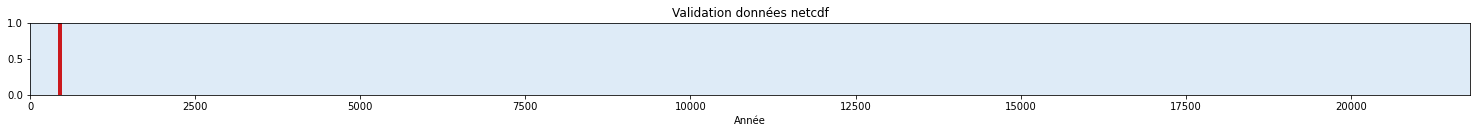

In [22]:
#FIRST = startDate
#LAST = endDate  # inclusive

anomaly = result.manquante

cmap = ListedColormap([
    '#08306b', '#08519c', '#2171b5', '#4292c6',
    '#6baed6', '#9ecae1', '#c6dbef', '#deebf7',
    '#fee0d2', '#fcbba1', '#fc9272', '#fb6a4a',
    '#ef3b2c', '#cb181d', '#a50f15', '#67000d',
])

cmap = ListedColormap([
    '#deebf7', '#cb181d',
])


fig = plt.figure(figsize=(20, 1))

ax = fig.add_axes([0, 0, 1, 1])
#ax.set_axis_off()# create a collection with a rectangle for each year

col = PatchCollection([
    Rectangle((y, 0), 1, 1)
    for y in range(result.manquante.size)
])

# set data, colormap and color limits

col.set_array(anomaly)
col.set_cmap(cmap)
#col.set_clim(reference - LIM, reference + LIM)
ax.add_collection(col)
ax.set_ylim(0, 1)
ax.set_xlim(0, result.manquante.size)
plt.title('Validation données netcdf')
plt.xlabel('Année')
plt.show()

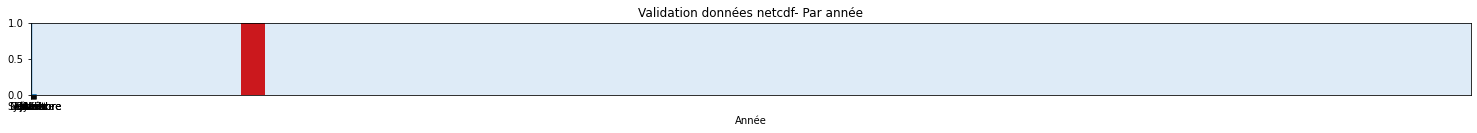

In [23]:
# graph des années où il y a des periodes manquantes

anomaly = result2.manquante

cmap = ListedColormap([
    '#08306b', '#08519c', '#2171b5', '#4292c6',
    '#6baed6', '#9ecae1', '#c6dbef', '#deebf7',
    '#fee0d2', '#fcbba1', '#fc9272', '#fb6a4a',
    '#ef3b2c', '#cb181d', '#a50f15', '#67000d',
])

cmap = ListedColormap([
    '#deebf7', '#cb181d',
])


fig = plt.figure(figsize=(20, 1))

ax = fig.add_axes([0, 0, 1, 1])
#ax.set_axis_off()# create a collection with a rectangle for each year

col = PatchCollection([
    Rectangle((y, 0), 1, 1)
    for y in range(result2.manquante.size)
])

# set data, colormap and color limits

col.set_array(anomaly)
col.set_cmap(cmap)
#col.set_clim(reference - LIM, reference + LIM)
ax.add_collection(col)
ax.set_ylim(0, 1)
ax.set_xlim(0, result2.manquante.size)
plt.title('Validation données netcdf- Par année')
plt.plot( result2['mois'], result2['manquante'])
plt.xlabel('Année')
plt.show()

### Représentation graphique - La taille

In [32]:
result['annee_mois']

0        2015-01
1        2015-01
2        2015-01
3        2015-01
4        2015-01
          ...   
21820    2022-06
21821    2022-06
21822    2022-06
21823    2022-06
21824    2022-06
Name: annee_mois, Length: 21825, dtype: object

In [20]:

result_taille=result.groupby(['annee','annee_mois'], as_index=False).mean()
result_taille 

annee annee_mois       size  manquante
0    2015    2015-01  72.941739   0.000000
1    2015    2015-02  58.127769   0.205357
2    2015    2015-03  71.876718   0.012097
3    2015    2015-04  73.146181   0.000000
4    2015    2015-05  74.530006   0.000000
..    ...        ...        ...        ...
85   2022    2022-02  73.660208   0.000000
86   2022    2022-03  73.405627   0.000000
87   2022    2022-04  73.725408   0.000000
88   2022    2022-05  75.146798   0.000000
89   2022    2022-06  74.416007   0.000000

[90 rows x 4 columns]

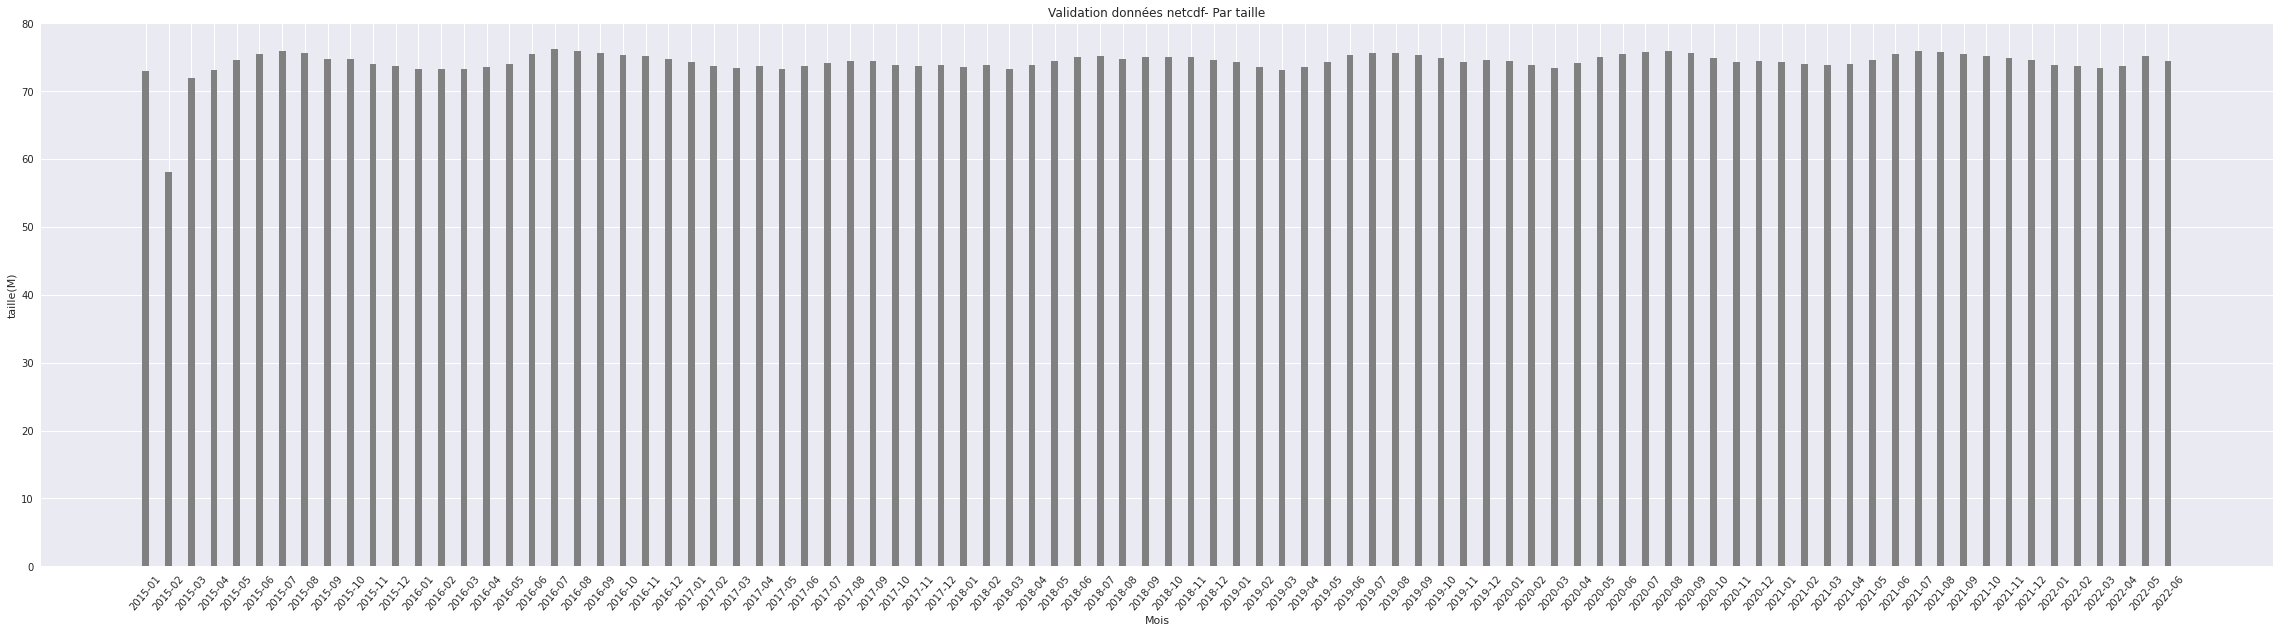

In [62]:

import matplotlib.pyplot as plt

plt.style.use('seaborn')
fig = plt.figure(figsize=(40, 10))
ax = fig.add_subplot(111)
ax.bar(result_taille['annee_mois'], result_taille['size'], color="gray",width=0.3)
plt.xticks(rotation=50, horizontalalignment="center")
plt.ylabel('taille(M)')
plt.xlabel('Mois')

plt.title('Validation données netcdf- Par taille')

plt.show(block=True);

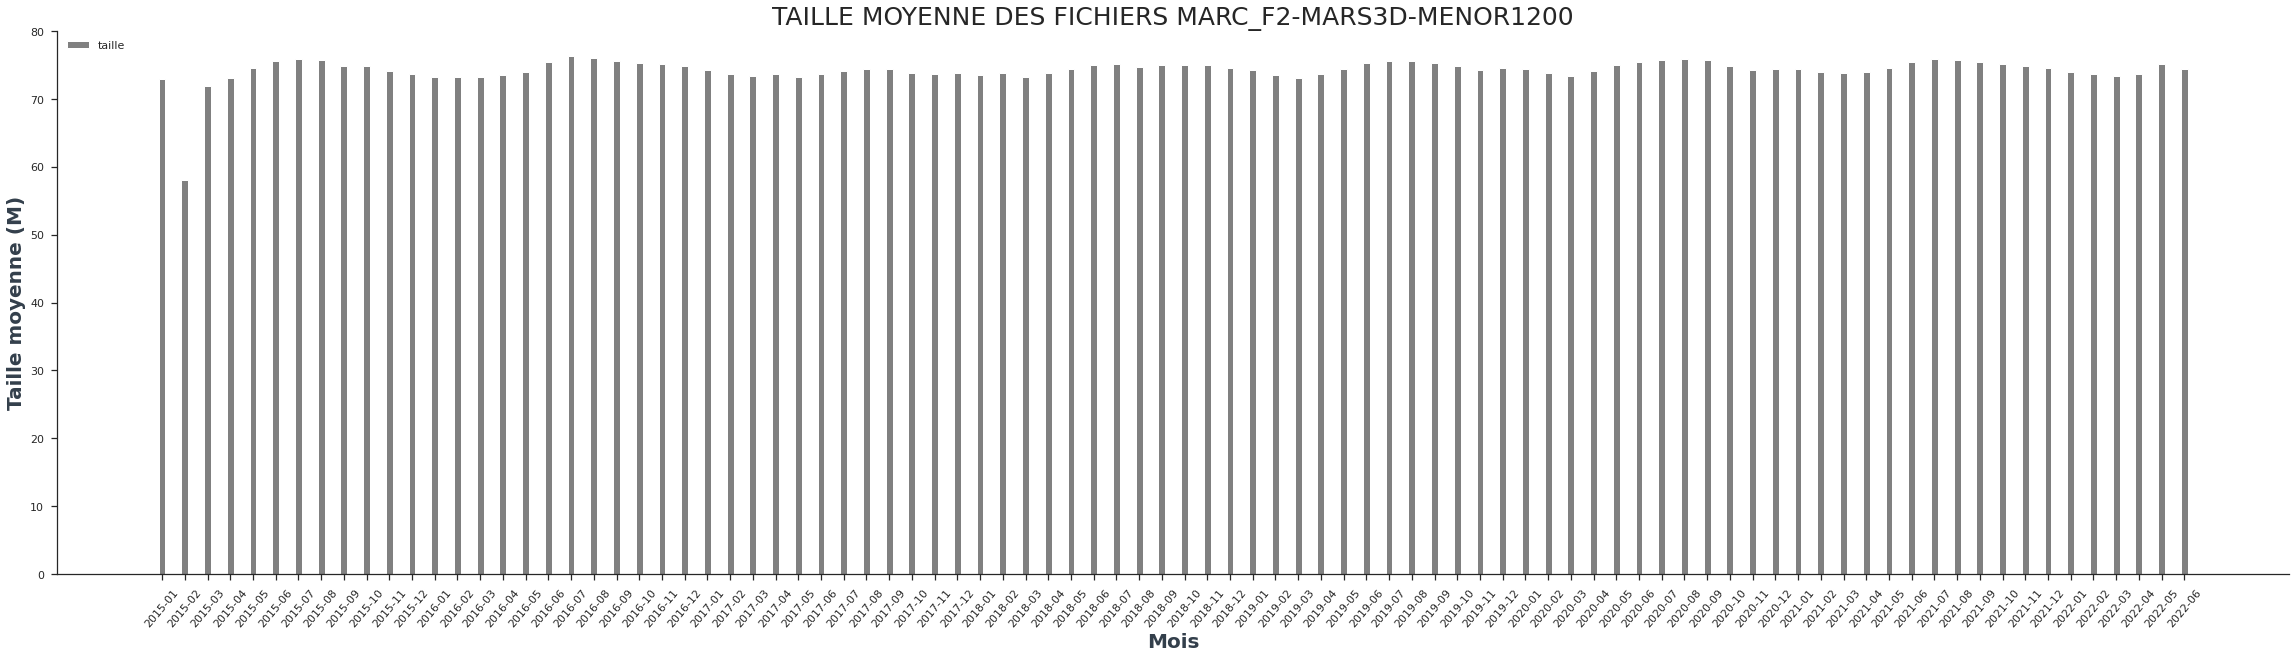

In [45]:

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
sns.set_theme(style='white')  # set background color
fig, ax = plt.subplots(figsize=(40,10))
plt.bar(result_taille['annee_mois'], result_taille['size'], color='gray' ,width=0.3)
plt.xticks(rotation=50, horizontalalignment="center") 
ax.set_xlabel('Mois', fontsize=20, fontweight='black', color = '#333F4B')
ax.set_ylabel('Taille moyenne (M)', fontsize=20, fontweight='black', color = '#333F4B')
plt.title('TAILLE MOYENNE DES FICHIERS'+ ' ' + config['config']['oco_name'] , fontsize=25 )
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.savefig("Valid_taille_moyenne_fichiers_"+config['config']['oco_name']+".png", dpi=50, bbox_inches='tight')

plt.show(block=True);

### Représentation graphique - Donées manquantes (avec Bar graph)

In [21]:
# indexation sur la date
resultCopy = result.copy()
resultCopy.set_index('dt_attendu',inplace=True)

result2Copy = result2.copy()
result2Copy.set_index('dt_attendu',inplace=True)

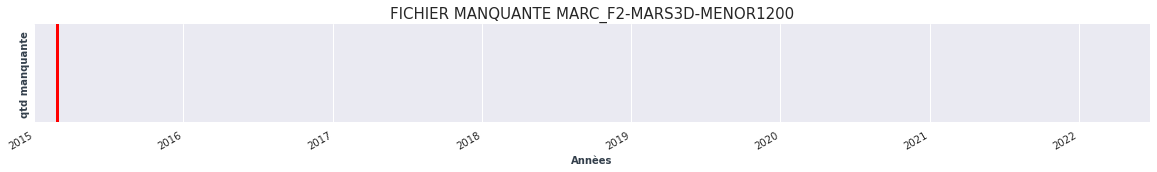

In [67]:
# graph des années complets 

fig = plt.figure(figsize=(20, 2))
ax = plt.gca()
ax.bar(resultCopy.index, resultCopy.manquante, width=1,color='red')
ax.yaxis.set_major_locator(ticker.NullLocator())
plt.gcf().autofmt_xdate()
plt.margins(0)
ax.set_xlabel('Annèes', fontsize=10, fontweight='black', color = '#333F4B')
ax.set_ylabel('qtd manquante', fontsize=10, fontweight='black', color = '#333F4B')
plt.title('FICHIER MANQUANTE'+ ' ' + config['config']['oco_name'] , fontsize=15)
plt.savefig("fichier_manquante_config['config']['oco_name'].png", dpi=300, bbox_inches='tight')

plt.show()



import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
sns.set_theme(style='white')  # set background color
fig, ax = plt.subplots(figsize=(40,10))
plt.bar(result_taille['annee_mois'], result_taille['size'], color='gray' ,width=0.3)
plt.xticks(rotation=50, horizontalalignment="center") 
ax.set_xlabel('Mois', fontsize=20, fontweight='black', color = '#333F4B')
ax.set_ylabel('Taille moyenne (M)', fontsize=20, fontweight='black', color = '#333F4B')
plt.title('TAILLE MOYENNE DES FICHIERS'+ ' ' + config['config']['oco_name'] , fontsize=25 )

for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(0.1)    # change width border
    ax.spines[axis].set_color('white')    # change color border

plt.savefig("Taille_moyenne_fichiers_"+config['config']['oco_name']+".png", dpi=50, bbox_inches='tight')

plt.show(block=True);




In [26]:

import matplotlib.ticker as ticker

fig = plt.figure(figsize=(20, 2))
ax = plt.gca()
ax.bar(resultCopy.index, resultCopy.manquante, width=1,color='red')
ax.yaxis.set_major_locator(ticker.NullLocator())
plt.gcf().autofmt_xdate()
plt.margins(0)
ax.set_xlabel('Annèes', fontsize=10, fontweight='black', color = '#333F4B')
ax.set_ylabel('manquante', fontsize=10, fontweight='black', color = '#333F4B')
plt.title('FICHIERS MANQUANTES -EMSEMBLE DE FICHIERS'+ ' ' + config['config']['oco_name'] , fontsize=15)

for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(0.1)    # change width border
    ax.spines[axis].set_color('white')    # change color border
    
plt.savefig("Valid_total_fichier_manquante_"+config['config']['oco_name']+".png", dpi=50, bbox_inches='tight')
plt.show()


In [51]:
# graph des années où il y a des periodes manquantes

import matplotlib.ticker as ticker
fig = plt.figure(figsize=(20, 2))
ax = plt.gca()
ax.bar(result2Copy.index, result2Copy.manquante, width=1,color='red')
ax.yaxis.set_major_locator(ticker.NullLocator())
plt.gcf().autofmt_xdate()
plt.margins(0)
ax.set_xlabel('Mois', fontsize=10, fontweight='black', color = '#333F4B')
plt.xticks(rotation=0, horizontalalignment="center") 
#ax.set_ylabel('manquante', fontsize=10, fontweight='black', color = '#333F4B')
plt.title('FICHIERS MANQUANTES- PAR MOIS'+ ' ' + config['config']['oco_name'] , fontsize=15)
plt.legend(['manquante'], loc='upper left')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

plt.savefig("Valid_annees_fichier_manquante_"+config['config']['oco_name']+".png", dpi=50, bbox_inches='tight')
plt.show()

In [66]:

#group by des dimensions n conformes
result_manq=result.groupby(['annee','manquante'], as_index=False)[['annee_mois','manquante']].sum()
result_manq 

annee  manquante
0   2015          0
1   2015         49
2   2016          0
3   2017          0
4   2018          0
5   2019          0
6   2020          0
7   2021          0
8   2022          0

In [20]:
#group by des dimensions n conformes
result_manq=result.groupby(['annee','manquante'], as_index=False)[['annee_mois','manquante']].sum()
result_manq 

annee  manquante
0   2015          0
1   2015         49
2   2016          0
3   2017          0
4   2018          0
5   2019          0
6   2020          0
7   2021          0
8   2022          0

In [24]:

#group by des dimensions n conformes
result_manq=result.groupby(['annee','manquante'], as_index=False)[['annee_mois','manquante']].sum()
  
plt.style.use('seaborn')
sns.set_theme(style='white')  # set background color
fig, ax = plt.subplots(figsize=(40,10))

plt.bar(result_manq['annee'], result_manq['manquante'], color='red' ,width=0.1)
plt.xticks(rotation=50, horizontalalignment="center") 
ax.set_xlabel('Année', fontsize=20, fontweight='black', color = '#333F4B')
ax.set_ylabel('Nombre de fichiers manquants', fontsize=20, fontweight='black', color = '#333F4B')
plt.title('FICHIERS MANQUANTS PAR ANNÉE'+ ' ' + config['config']['oco_name'] , fontsize=25)


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
    
plt.savefig("Valid_manquants_par_annee_"+config['config']['oco_name']+".png", dpi=40, bbox_inches='tight')

plt.show(block=True);



In [54]:

#group by des dimensions n conformes
result_manq_mois=result2.groupby(['annee','annee_mois','manquante'], as_index=False)[['manquante']].sum()
result_manq_mois 


annee annee_mois  manquante
0    2015    2015-01          0
1    2015    2015-02          0
2    2015    2015-02         46
3    2015    2015-03          0
4    2015    2015-03          3
5    2015    2015-04          0
6    2015    2015-05          0
7    2015    2015-06          0
8    2015    2015-07          0
9    2015    2015-08          0
10   2015    2015-09          0
11   2015    2015-10          0
12   2015    2015-11          0
13   2015    2015-12          0

In [ ]:

plt.style.use('seaborn')
sns.set_theme(style='white')  # set background color
fig1, ax = plt.subplots(figsize=(40,10))

g1 = plt.bar(result_manq_mois['annee_mois'], result_manq_mois['manquante'], color='red' ,width=0.1)
plt.xticks(rotation=50, horizontalalignment="center") 
ax.set_xlabel('Mois', fontsize=20, fontweight='black', color = '#333F4B')
ax.set_ylabel('Nombre de fichiers manquants', fontsize=20, fontweight='black', color = '#333F4B')
plt.title('FICHIERS MANQUANTS PAR MOIS'+ ' ' + config['config']['oco_name'] , fontsize=25)


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

plt.savefig("Valid_manquants_par_mois_"+config['config']['oco_name']+".png", dpi=40, bbox_inches='tight')
pp.show(block=True)
 

 # Vérification dans le fichier

verifier:
tailes des dimensions ni , nj, time et level si 3D pour chaque fichier
nombre de variables 2d et 3d par fichier
level =le nombre de niveaux selon la verticale du fichier


# extra

In [ ]:
# liste des dates des vrais fichiers _ using split   
import glob
real_files = []
for file in glob.glob(os.path.join(refDir,'*',filePrefix+'_'+'*Z.nc')):
    date=file.split("_")[4].split('.')[0]  #selectione le contenu apres le dernier '_' et avant le '.csv'
    date2=date.split("T")[0]+date.split("T")[1].split('Z')[0]+'00'
    date3=date2[0:4]+'-'+date2[4:6]+'-'+date2[6:8]+' '+date2[8:10]+':'+date2[10:12]+':00'
    datetime_object=pd.to_datetime(str(date3), format="%Y-%m-%d %H:%M:%S")
    real_files.append(datetime_object)
    real_files.sort()

In [ ]:
df = pd.DataFrame(columns=('date','XE','TEMP','UZ','VZ'))

In [16]:
df

Empty DataFrame
Columns: [date, XE, TEMP, UZ, VZ]
Index: []

In [43]:
for d in ldate :
    dFormatted = d.strftime(config['config']['date_format'])
    fileName = os.path.join(refDir,str(d.year),filePrefix+'_'+dFormatted+".nc")
    if not os.path.isfile(fileName):
        print(f"le fichier {fileName} n'existe pas")
    else:
        ds = xr.open_dataset(fileName)
        meanXE = float(ds.XE.mean().values)
        meanTEMP = float(ds.TEMP.mean().values)
        meanUZ = float(ds.UZ.mean().values)
        meanVZ = float(ds.VZ.mean().values)
        print({'XE':meanXE,'TEMP':meanTEMP,'UZ':meanUZ,'VZ':meanVZ})

{'XE': -1.0970548391342163, 'TEMP': 10.644299507141113, 'UZ': -0.03825554624199867, 'VZ': -0.0019773137755692005}
{'XE': -0.6066904067993164, 'TEMP': 10.641364097595215, 'UZ': -0.02297166734933853, 'VZ': 0.017781030386686325}
{'XE': -0.04937874153256416, 'TEMP': 10.638510704040527, 'UZ': 0.0005526483291760087, 'VZ': 0.030001716688275337}
{'XE': 0.4375571608543396, 'TEMP': 10.636423110961914, 'UZ': 0.023163141682744026, 'VZ': 0.033950116485357285}
{'XE': 0.7300512194633484, 'TEMP': 10.63506031036377, 'UZ': 0.03936666250228882, 'VZ': 0.030264802277088165}
{'XE': 0.7448481321334839, 'TEMP': 10.63429069519043, 'UZ': 0.047571174800395966, 'VZ': 0.0175317395478487}
{'XE': 0.4668453633785248, 'TEMP': 10.633822441101074, 'UZ': 0.04743350297212601, 'VZ': -0.004223092459142208}
{'XE': -0.03925136476755142, 'TEMP': 10.63359546661377, 'UZ': 0.03651556745171547, 'VZ': -0.029935555532574654}
{'XE': -0.6462739706039429, 'TEMP': 10.63382339477539, 'UZ': 0.013769634068012238, 'VZ': -0.05096182972192764